In [1]:
import tensorflow as tf
import tf_util
import numpy as np
import pickle
import os
import time
from matplotlib import pyplot as plt
import gym
import random
import mujoco_py
import load_policy

%load_ext autoreload
%autoreload 2

def set_seed(seed_number):
    os.environ['PYTHONHASHSEED']=str(seed_number)
    random.seed(seed_number)
    np.random.seed(seed_number)
    tf.set_random_seed(seed_number)
    
def split_data(data):
    x, y = data['observations'], data['actions']
    n = x.shape[0]
    arr = np.arange(n)
    np.random.shuffle(arr)
    x, y = data['observations'][arr], data['actions'][arr]
    x_train, y_train = x[:int(0.6*n)], y[:int(0.6*n)]
    x_val, y_val = x[int(0.6*n):int(0.8*n)], y[int(0.6*n):int(0.8*n)]
    x_test, y_test = x[int(0.8*n):], y[int(0.8*n):]
    return x_train, y_train, x_val, y_val, x_test, y_test

def get_session(): # use with get_session() as sess: or sess = get_session()
    tf.reset_default_graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [2]:
# take a look at the dimension of state and action in each game environment
env_name = ['Ant-v2', 'HalfCheetah-v2', 'Hopper-v2', 'Humanoid-v2', 'Reacher-v2', 'Walker2d-v2']
for game in env_name:
    env = gym.make(game)
    s = env.reset()
    print(game, s.shape, env.action_space) #env.action_space.sample()
    print(env.action_space.sample())

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Ant-v2 (111,) Box(8,)
[ 0.09762701  0.43037874  0.20552675  0.08976637 -0.1526904   0.29178822
 -0.12482557  0.78354603]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
HalfCheetah-v2 (17,) Box(6,)
[ 0.92732555 -0.23311697  0.5834501   0.05778984  0.13608912  0.85119325]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Hopper-v2 (11,) Box(3,)
[-0.85792786 -0.8257414  -0.9595632 ]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box 

# Behavior cloning

#### 0. setup function

In [3]:
def load_split_data(data, game):
    # load experts data
    with open('./expert_data/'+str(data)+'.pkl', 'rb') as handle:
        human = pickle.load(handle)
    #print('observation', human['observations'].shape)
    #print('action', human['actions'].shape)
    #print()
    #print('observation example \n', human['observations'][0])
    #print('action example \n', human['actions'][0])
    x_train, y_train, x_val, y_val, x_test, y_test = split_data(human)
    
    env = gym.make(game)
    num_action = len(env.action_space.sample())
    num_state = env.reset().shape[0]
    return x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state

In [22]:
# define mlp nets
def model(state_dim, action_dim):
    state = tf.placeholder(tf.float32, [None, state_dim])
    action = tf.placeholder(tf.float32, [None, 1, action_dim])
    if state_dim > 100:
        with tf.variable_scope('fc'):
            fc1 = tf.contrib.layers.fully_connected(state, 1024)
            fc2 = tf.contrib.layers.fully_connected(fc1, 1024)
            fc3 = tf.contrib.layers.fully_connected(fc2, 512)
            fc4 = tf.contrib.layers.fully_connected(fc3, 256)
            out = tf.contrib.layers.fully_connected(fc4, action_dim, activation_fn=None)   
    else:
        with tf.variable_scope('fc'):
            fc1 = tf.contrib.layers.fully_connected(state, 512)
            fc2 = tf.contrib.layers.fully_connected(fc1, 512)
            out = tf.contrib.layers.fully_connected(fc2, action_dim, activation_fn=None)           
    
    out = tf.reshape(out, [tf.shape(state)[0], 1, action_dim])
    return state, action, out

def loss_function(pred, label):
    loss = tf.losses.mean_squared_error(pred, label)
    return loss

def optimizer(loss, lr = 1e-4):
    train_step = tf.train.AdamOptimizer(lr, epsilon=1e-4).minimize(loss)
    return train_step

In [5]:
# train nn
def train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, 
             y_val, x_test, y_test, plot = True, lr = None, verbose = True, evaluate=False, env = None):
    set_seed(1)
    
    if evaluate:
        eval_list = []
        
    state, action, out = model(num_state, num_action)
    mean_loss = loss_function(out, action)
    train_step = optimizer(mean_loss)
    
    var= tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    sess.run(tf.global_variables_initializer())    
    
    for i in range(epoch):
        loss_his, loss_his2, loss_his3 = [], [], []
        for j in range(int(x_train.shape[0]/batch_size)):
            _, loss_train = sess.run([train_step, mean_loss], feed_dict=
                                     {state:x_train[j*batch_size:(j+1)*batch_size], action:y_train[j*batch_size:(j+1)*batch_size]})
            loss_his.append(loss_train)
        
            loss_val = sess.run([mean_loss], feed_dict={state:x_val[j*batch_size2:(j+1)*batch_size2]
                                                                                , action:y_val[j*batch_size2:(j+1)*batch_size2]})
            loss_test = sess.run([mean_loss], feed_dict={state:x_test[j*batch_size2:(j+1)*batch_size2]
                                                                                , action:y_test[j*batch_size2:(j+1)*batch_size2]})
            loss_his2.append(loss_val)
            loss_his3.append(loss_test)
            
        if evaluate and i % 5 == 0:
            returns = []
            for _ in range(25):
                steps = 0
                obs = env.reset()
                done = False
                totalr = 0

                while not done:
                    act = sess.run(out, feed_dict={state:obs.reshape(1, -1)})
                    obs, r, done, _ = env.step(act)
                    totalr += r
                    steps += 1
                returns.append(totalr)
            eval_list.append((np.mean(returns), np.std(returns)))        
            
        if verbose:
            print('\n'+str(i)+' epoch: '+'train loss', loss_train)
            print('val loss: '+ str(np.mean(np.array(loss_his2)))+' test loss: ',str(np.mean(np.array(loss_his3))) )
        if plot and i % 10 == 0:
            plt.plot(loss_his)
            plt.title('Loss train')
            plt.show()
        
    if evaluate:
        return sess, state, action, out, eval_list
    else:
        return sess, state, action, out

In [6]:
# evaluate policy of trained agent
def eval_policy(game, num_rollouts, sess, state, out, env, verbose = True, render = False, data_gen = False):
    returns = []
    
    for i in range(num_rollouts):
        steps = 0
        obs = env.reset()
        if i == 0 and data_gen:
            data_pi = obs.reshape(1, -1)
        done = False
        totalr = 0

        while not done:
            action = sess.run(out, feed_dict={state:obs.reshape(1, -1)})
            obs, r, done, _ = env.step(action)
            if data_gen:
                data_pi = np.concatenate([data_pi, obs.reshape(1,-1)])
            totalr += r
            steps += 1
            if render:
                env.render()
        returns.append(totalr)
        if verbose:
            print('\niter', i)
            print('mean return', np.mean(returns))
            print('std of return', np.std(returns))
        else:
            if i == num_rollouts-1:
                print('mean return', np.mean(returns))
                print('std of return', np.std(returns))
    
    if data_gen:
        return returns, data_pi
    else:
        return returns

#### 1. HalfCheetah

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

0 epoch: train loss 0.025257524
val loss: 0.06343903 test loss:  0.06350469


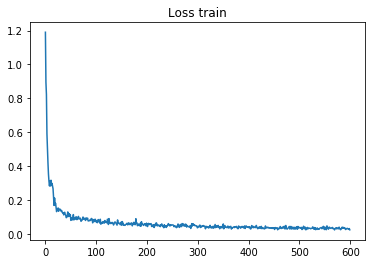


1 epoch: train loss 0.016492262
val loss: 0.026394816 test loss:  0.026111968

2 epoch: train loss 0.013145345
val loss: 0.019125255 test loss:  0.019053373

3 epoch: train loss 0.010845466
val loss: 0.015205869 test loss:  0.015216446

4 epoch: train loss 0.00925276
val loss: 0.012856992 test loss:  0.012908925

5 epoch: train loss 0.008053942
val loss: 0.011267782 test loss:  0.011324412

6 epoch: train loss 0.00732118
val loss: 0.010070253 test loss:  0.010120205

7 epoch: train loss 0.006636098
val loss: 0.009141886 test loss:  0.0091923475

8 epoch: train loss 0.005974993
val loss: 0.008389806 test loss:  0.008434259

9 epoch: train loss 0.005465185
val loss: 0.007781353 test loss:  0.007811284
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

iter 0
mean return 3999.9040264328855
std of return 0.0

iter 1
mean return 3930.4187380792

In [7]:
# split data, create env
data = 'HalfCheetah-v22'
game = 'HalfCheetah-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

# training deep neural nets
seed = 1
set_seed(seed)
sess = get_session()
it_num = int(1e+5)
batch_size = 100
batch_size2 = int(batch_size/3)
epoch = 10
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test)

# evaluate policy of trained agent
env = gym.make(game)
num_rollouts = 100
returns = []
returns = eval_policy(game, num_rollouts, sess, state, out, env)

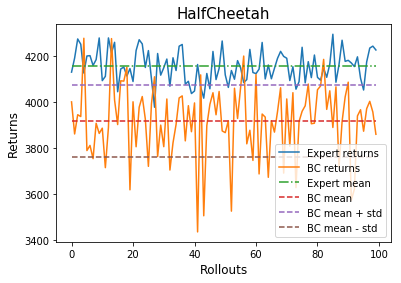

<Figure size 432x288 with 0 Axes>

In [20]:
# plot returns of BC and experts
plt.plot(expert,label = 'Expert returns')
plt.plot(returns, label = 'BC returns')
plt.xlabel('Rollouts', size=12)
plt.ylabel('Returns',size =12)
expert = [4128.728383502425, 4189.535684673227, 4272.43303667612, 4249.560423016207, 4124.772769049202, 4198.7097924364125, 4200.1419735573745, 4157.776701879373, 4183.002617459517, 4276.806235453813, 4091.9185494035255, 4110.495515510108, 4276.9212743364515, 4211.965179413419, 4257.969935553734, 4043.885796969095, 4142.499163256315, 4150.679691581168, 4112.035436378099, 4144.082152181334, 4088.0712633445924, 4222.320207777014, 4269.064293269311, 4250.906939027812, 4148.951248388147, 4222.023925064402, 4098.925831355091, 3976.6875579460834, 4209.380638842714, 4115.734884418981, 4147.831670044442, 4185.394716315659, 4067.801853424089, 4190.939196720014, 4135.750687511855, 4241.12220146413, 4248.600645493026, 4076.5123996714224, 4089.116529174026, 4036.020140445872, 4047.0686695754534, 4161.7820300860285, 4064.3324558793024, 4015.9265603773433, 4122.9001866605395, 4056.6786930649814, 4218.364321840599, 4096.500474489058, 4144.684147770466, 4263.584984166652, 4116.606466006029, 4062.521071746634, 4135.656341300057, 4097.933123609351, 4178.558245317028, 4146.867606323324, 4083.399670997339, 4096.388304382819, 4227.133001891338, 4127.106261158067, 4122.227998151923, 4141.7516718342695, 4257.282575178695, 4099.169477649469, 4159.645790167006, 4099.959176133804, 4145.190574195959, 4188.549485786253, 4218.614841959601, 4196.916768206129, 4188.857668924531, 4092.3066926686647, 4152.206825351386, 4054.9296687822607, 4087.5672154644267, 4236.416859209656, 4082.4200891082974, 4174.03411470297, 4104.986535282874, 4202.833953389136, 4106.019843779324, 4093.815304044671, 4145.191533113684, 4106.467003824522, 4163.7244443784775, 4292.848002944813, 4085.0320479459824, 4161.563694890181, 4266.924476517376, 4175.447192583615, 4179.846330812467, 4168.484682905271, 4152.822904171786, 4194.979992335082, 4102.46226750325, 4051.3197245830893, 4173.358193314855, 4232.962184045349, 4241.348806201747, 4224.688252340227]
plt.plot(np.mean(expert)*np.ones((100,)), label = 'Expert mean', linestyle='-.')
plt.plot(np.mean(returns)*np.ones((100,)), label = 'BC mean', linestyle='--')
plt.plot(np.mean(returns)*np.ones((100,))+np.std(returns), label = 'BC mean + std', linestyle='--')
plt.plot(np.mean(returns)*np.ones((100,))-np.std(returns), label = 'BC mean - std', linestyle='--')
plt.title('HalfCheetah', size = 15)
plt.legend()
plt.figure()
plt.show()

In [18]:
# performance w.r.t epoch

# split data, create env
data = 'HalfCheetah-v22'
game = 'HalfCheetah-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)
env = gym.make(game)
sess = get_session()

# training deep neural nets
seed = 1
set_seed(seed)
it_num = int(1e+5)
batch_size = 100
batch_size2 = int(batch_size/3)
epoch = 30

sess, state, action, out, eval_list = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train,
                                        y_train, x_val, y_val, x_test, y_test, plot = False, verbose = False, evaluate=True, env = env)



WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


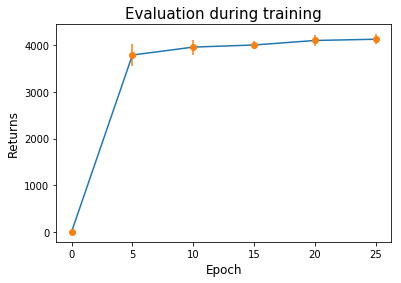

In [21]:
#plot mean and std w.r.t epoch
xrange = [0, 5,10,15,20,25]
mean, std = [], []
for idx, i in enumerate(eval_list):
    mean.append(i[0])
    std.append(i[1])
        
plt.plot(xrange, mean)
plt.errorbar(xrange, mean, std, linestyle='None', marker='o')
        
plt.xlabel('Epoch', size=12)
plt.ylabel('Returns',size =12)
plt.title('Evaluation during training', size = 15)
plt.show()  

#### 2. Humanoid-v2

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 1.0832404
val loss: 1.4100033 test loss:  1.3398864


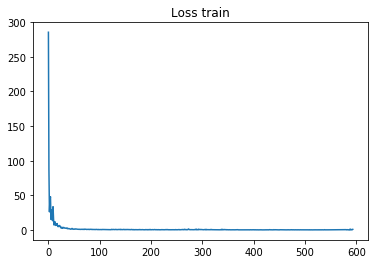


1 epoch: train loss 0.44663972
val loss: 0.42903402 test loss:  0.41893685

2 epoch: train loss 0.36714926
val loss: 0.26511103 test loss:  0.26519817

3 epoch: train loss 0.72940695
val loss: 0.26707968 test loss:  0.26352572

4 epoch: train loss 0.39374387
val loss: 0.20343398 test loss:  0.20011325

5 epoch: train loss 0.2742453
val loss: 0.17696711 test loss:  0.17713863

6 epoch: train loss 0.24957114
val loss: 0.16761197 test loss:  0.16595381

7 epoch: train loss 0.2798971
val loss: 0.13525939 test loss:  0.13621013

8 epoch: train loss 0.17632234
val loss: 0.12841098 test loss:  0.12901658

9 epoch: train loss 0.21007413
val loss: 0.1246128 test loss:  0.12523854

10 epoch: train loss 0.17305133
val loss: 0.111043036 test loss:  0.11155608


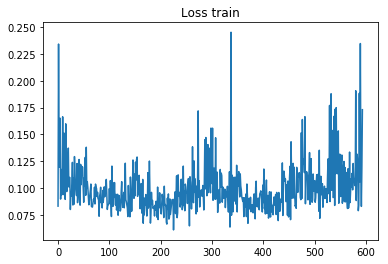


11 epoch: train loss 0.09639164
val loss: 0.10306423 test loss:  0.10291035

12 epoch: train loss 0.17518745
val loss: 0.09489968 test loss:  0.09603526

13 epoch: train loss 0.100222744
val loss: 0.09182634 test loss:  0.09253563

14 epoch: train loss 0.08559121
val loss: 0.082682766 test loss:  0.08307265

15 epoch: train loss 0.08293188
val loss: 0.080362976 test loss:  0.08068513

16 epoch: train loss 0.074999064
val loss: 0.07772209 test loss:  0.07786461

17 epoch: train loss 0.065172166
val loss: 0.07320184 test loss:  0.07361125

18 epoch: train loss 0.0718381
val loss: 0.070788875 test loss:  0.07151902

19 epoch: train loss 0.06536998
val loss: 0.06809304 test loss:  0.06897583

20 epoch: train loss 0.062485874
val loss: 0.06645471 test loss:  0.067179374


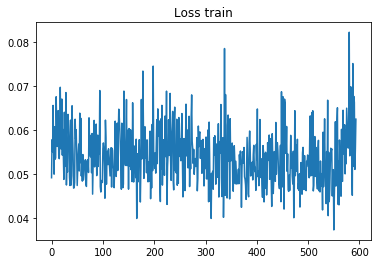


21 epoch: train loss 0.052682314
val loss: 0.064334005 test loss:  0.06509407

22 epoch: train loss 0.051464953
val loss: 0.061608747 test loss:  0.062473286

23 epoch: train loss 0.050906457
val loss: 0.060653698 test loss:  0.061319947

24 epoch: train loss 0.048618406
val loss: 0.05889167 test loss:  0.059434447
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

iter 0
mean return 820.4321910461013
std of return 0.0

iter 1
mean return 765.2017926138217
std of return 55.230398432279515

iter 2
mean return 678.7378103127229
std of return 130.32896228923303

iter 3
mean return 609.9750185672659
std of return 164.08593295718111

iter 4
mean return 605.2504429364601
std of return 147.0667915442084

iter 5
mean return 566.6877302506233
std of return 159.55964933019573

iter 6
mean return 580.8246095673186
std of return 151.72788007881184

it

In [23]:
# split data, create env
data = 'Humanoid-v2'
game = 'Humanoid-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

# training deep neural nets
seed = 1
set_seed(seed)
sess = get_session()
it_num = int(1e+5)
batch_size = 100
batch_size2 = int(batch_size/3)
epoch = 25
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test)

# evaluate policy of trained agent
env = gym.make(game)
num_rollouts = 100
returns = []
returns = eval_policy(game, num_rollouts, sess, state, out, env)

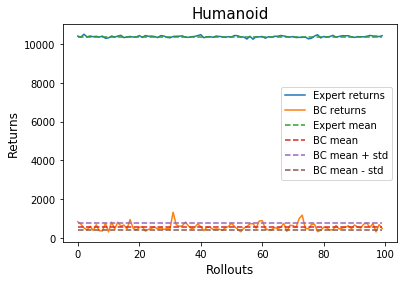

<Figure size 432x288 with 0 Axes>

In [26]:
# plot returns of BC and experts
plt.xlabel('Rollouts', size=12)
plt.ylabel('Returns',size =12)
expert =[10419.409549756423, 10365.596859133868, 10516.850502423105, 10376.830181271234, 10427.779294720529, 10388.847497246572, 10408.610218583448, 10372.125302646979, 10421.390629910084, 10307.178185200151, 10329.030978337854, 10424.468031920993, 10369.961449509961, 10421.787297315537, 10461.307088792031, 10342.350588157147, 10376.370750305792, 10402.964418737272, 10371.974359752254, 10374.59612505884, 10448.97933295502, 10352.5708219231, 10450.59055171854, 10412.355883575961, 10420.713243147919, 10397.065155831213, 10343.639733722554, 10446.705955063473, 10424.611637832402, 10355.295220258122, 10331.617251594695, 10403.153104764322, 10413.603220716777, 10416.64359672373, 10433.22769647793, 10364.762949189671, 10356.7904948763, 10391.613780879292, 10403.091204043783, 10444.134438863053, 10495.777044602743, 10337.121431152875, 10382.948291831544, 10395.719260507067, 10357.637895619248, 10423.231879697998, 10402.848370128208, 10389.610259800198, 10354.941645251347, 10393.671995136381, 10376.277347034345, 10454.420563552994, 10437.940459609481, 10377.794324011986, 10374.683341540167, 10269.06269005753, 10410.397348820205, 10259.409471616731, 10389.134034294631, 10378.642848795065, 10403.347009747093, 10309.945737003798, 10388.556008746631, 10366.40302241922, 10413.349967818365, 10411.865543191889, 10450.882491017288, 10427.81301896302, 10393.616853321555, 10367.495930127654, 10399.427990465596, 10345.753524247633, 10356.846183790896, 10356.504217291402, 10369.768531720552, 10278.824537987273, 10309.104411868464, 10423.638844825542, 10492.609712183732, 10325.856409988437, 10403.108377864995, 10363.060785586586, 10401.853368714717, 10458.786999886543, 10367.24688145237, 10402.91164552021, 10441.217423477883, 10436.978276052872, 10439.009399701887, 10381.671207710759, 10351.689728831654, 10393.814207728174, 10386.806753897152, 10384.27391102289, 10410.984012929108, 10455.194193704327, 10426.75293814065, 10421.503657670373, 10394.375386521438, 10442.298805358512]
plt.plot(expert,label = 'Expert returns')
plt.plot(returns, label = 'BC returns')
plt.plot(np.mean(expert)*np.ones((100,)), label = 'Expert mean', linestyle = '--')
plt.plot(np.mean(returns)*np.ones((100,)), label = 'BC mean', linestyle = '--')
plt.plot(np.mean(returns)*np.ones((100,)) + np.std(returns), label = 'BC mean + std', linestyle = '--')
plt.plot(np.mean(returns)*np.ones((100,)) - np.std(returns), label = 'BC mean - std', linestyle = '--')
plt.legend()
plt.title('Humanoid', size = 15)
plt.figure()
plt.show()

# DAgger

In [75]:
# define helper function for labeling
def label_data(game, data_pi):
    import tf_util
    policy_fn = load_policy.load_policy('./experts/'+ str(game)+'.pkl')
    action_list = []
    with tf.Session():
        tf_util.initialize()
        for idx, obs in enumerate(data_pi):
            action = policy_fn(obs[None,:])
            action_list.append(action)
    d_pi_action = np.array(action_list)
    return d_pi_action

# Define aggregation function
def aggregate(o1, a1, o2, a2):
    o = np.vstack((o1, o2))
    a = np.concatenate((a1, a2), axis = 0)
    
    # shuffle dataset
    n = o.shape[0]
    arr = np.arange(n)
    np.random.shuffle(arr)
    o, a = o[arr], a[arr]
    return o, a

def run_expert(game, num_rollouts, it):
    env=gym.make(str(game))
    mean, std = [], []
    import tf_util
    policy_fn = load_policy.load_policy('./experts/'+ str(game)+'.pkl')
    action_list = []
    with tf.Session():
        tf_util.initialize()
        for _ in range(it):
            returns = []
            for i in range(num_rollouts):
                obs = env.reset()
                done = False
                totalr = 0.
                steps = 0
                while not done:
                    action = policy_fn(obs[None,:])
                    obs, r, done, _ = env.step(action)
                    totalr += r
                    steps += 1
                returns.append(totalr)
            mean.append(np.mean(returns))
            std.append(np.std(returns))
    return returns, mean, std            

obs (1, 376) (1, 376)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 1.5982586
val loss: 1.4157785 test loss:  1.3496182


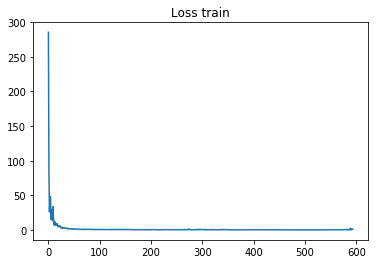


1 epoch: train loss 0.70826674
val loss: 0.44001755 test loss:  0.4294089

2 epoch: train loss 0.48086163
val loss: 0.2873306 test loss:  0.27944675

3 epoch: train loss 0.22614078
val loss: 0.223009 test loss:  0.21868101

4 epoch: train loss 0.41833338
val loss: 0.20803595 test loss:  0.2064093

5 epoch: train loss 0.49729407
val loss: 0.20268935 test loss:  0.20503633

6 epoch: train loss 0.15673655
val loss: 0.15950505 test loss:  0.15949728

7 epoch: train loss 0.32977825
val loss: 0.13635565 test loss:  0.13845253

8 epoch: train loss 0.12928401
val loss: 0.13387646 test loss:  0.1311635

9 epoch: train loss 0.11016926
val loss: 0.118331656 test loss:  0.11814618

10 epoch: train loss 0.17951262
val loss: 0.10896745 test loss:  0.109223455


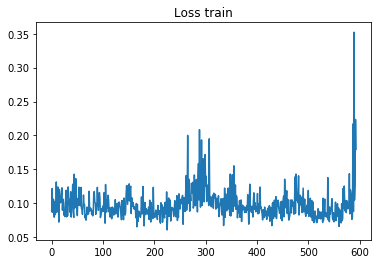


11 epoch: train loss 0.11430981
val loss: 0.10041392 test loss:  0.10060497

12 epoch: train loss 0.10827465
val loss: 0.09508426 test loss:  0.09494105

13 epoch: train loss 0.08847622
val loss: 0.08962206 test loss:  0.08934259

14 epoch: train loss 0.08295266
val loss: 0.08450704 test loss:  0.08484335

15 epoch: train loss 0.079944395
val loss: 0.08003237 test loss:  0.0801406

16 epoch: train loss 0.083732
val loss: 0.07865684 test loss:  0.07901424

17 epoch: train loss 0.071900114
val loss: 0.074025646 test loss:  0.074815914

18 epoch: train loss 0.06248648
val loss: 0.07066074 test loss:  0.07106822

19 epoch: train loss 0.060251843
val loss: 0.06887798 test loss:  0.06949573

20 epoch: train loss 0.05550023
val loss: 0.0662373 test loss:  0.066936925


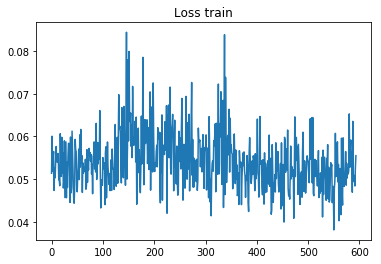


21 epoch: train loss 0.05379518
val loss: 0.064059846 test loss:  0.06422868

22 epoch: train loss 0.053759433
val loss: 0.06218647 test loss:  0.06282572

23 epoch: train loss 0.053457197
val loss: 0.060777746 test loss:  0.061178952

24 epoch: train loss 0.052910354
val loss: 0.05951211 test loss:  0.06000452

iter 0
mean return 393.8631631150297
std of return 0.0

iter 1
mean return 565.6126807393264
std of return 171.7495176242967

iter 2
mean return 521.0888211814948
std of return 153.72056686068424

iter 3
mean return 549.5197731447861
std of return 141.94177184886234

iter 4
mean return 545.5416821089561
std of return 127.20563709849101

iter 5
mean return 527.1584466312349
std of return 123.1832449016812

iter 6
mean return 504.0754877635707
std of return 127.2922601904032

iter 7
mean return 514.3229322888814
std of return 122.11869390649768

iter 8
mean return 538.5575511925385
std of return 133.99444825009502

iter 9
mean return 538.9123888948968
std of return 127.122752227


iter 111
mean return 535.0187472013287
std of return 158.7191928049698

iter 112
mean return 535.8567767154472
std of return 158.26402910188395

iter 113
mean return 534.1061738306195
std of return 158.66344554369738

iter 114
mean return 534.7392055338015
std of return 158.11662452798078

iter 115
mean return 533.9428774836636
std of return 157.66505049887613

iter 116
mean return 532.6564706292058
std of return 157.60001922437743

iter 117
mean return 532.061148007589
std of return 157.06286121305837

iter 118
mean return 530.9665676103749
std of return 156.85285637624037

iter 119
mean return 531.2977260081547
std of return 156.2397046390148

iter 120
mean return 530.599926176316
std of return 155.78040228198404

iter 121
mean return 531.3804104096148
std of return 155.3780143921361

iter 122
mean return 532.98195426582
std of return 155.75291741888063

iter 123
mean return 532.8183412909318
std of return 155.1342226318164

iter 124
mean return 532.2728753683866
std of return 154.6


iter 224
mean return 525.7115384517782
std of return 159.74463890898264

iter 225
mean return 524.8898085221991
std of return 159.86671206329964

iter 226
mean return 524.2736385771882
std of return 159.78292303251868

iter 227
mean return 524.5774446547796
std of return 159.4978304866671

iter 228
mean return 525.2786636527268
std of return 159.50102695680806

iter 229
mean return 524.7633500100421
std of return 159.34483650167596

iter 230
mean return 524.3778401601179
std of return 159.10701505827086

iter 231
mean return 524.403628233248
std of return 158.76422550461302

iter 232
mean return 524.9509633085743
std of return 158.64236590857914

iter 233
mean return 524.4700393046417
std of return 158.4731439349709

iter 234
mean return 524.2106657167709
std of return 158.18537432766936

iter 235
mean return 524.3860653777206
std of return 157.87277921201576

iter 236
mean return 524.517363079048
std of return 157.55227407626458

iter 237
mean return 523.7794639338113
std of return 1

In [35]:
# setup for DAgger
game = 'Humanoid-v2'
data = 'Humanoid-v2'
policy_fn = load_policy.load_policy('./experts/'+ str(game)+'.pkl')
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

seed, it_num, batch_size, epoch, num_rollouts = 1, 1e+5, 100, 25, 300
batch_size2  =  int(batch_size/3)
set_seed(seed)
sess = get_session()
env = gym.make(game)

# 1. train from human(expert) Data
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test, evaluate= True, env = env)

# 2. run trained policy to get dataset D_pi
returns, data_pi = eval_policy(game, num_rollouts, sess, state, out, env, data_gen = True, verbose = True)

# 3.ask human to label D_pi with action 
d_pi_action = label_data(game, data_pi)

# 4. aggregate two dataset
new_xt, new_yt = aggregate(x_train, y_train, data_pi, d_pi_action)

In [28]:
# load dataset 5-0
new_yt = np.load('./expert_data/mixed/mixedHumanoid-v2action2.npy')
new_xt = np.load('./expert_data/mixed/mixedHumanoid-v2obs2.npy')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 0.77589935
val loss: 1.0092452 test loss:  0.98838913


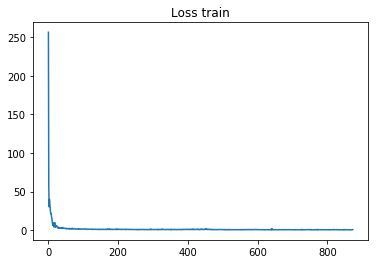


1 epoch: train loss 0.6078448
val loss: 0.24437174 test loss:  0.2375703

2 epoch: train loss 0.42817578
val loss: 0.19294637 test loss:  0.18313237

3 epoch: train loss 0.36667907
val loss: 0.16141777 test loss:  0.1541758

4 epoch: train loss 0.36384723
val loss: 0.12526941 test loss:  0.12169307

5 epoch: train loss 0.4609207
val loss: 0.11257443 test loss:  0.109272696

6 epoch: train loss 0.31893367
val loss: 0.09571136 test loss:  0.094918676

7 epoch: train loss 0.30663612
val loss: 0.08585911 test loss:  0.08432073

8 epoch: train loss 0.2505818
val loss: 0.07765299 test loss:  0.0768479

9 epoch: train loss 0.20998785
val loss: 0.07140013 test loss:  0.070980944

10 epoch: train loss 0.19610891
val loss: 0.06690634 test loss:  0.06650574


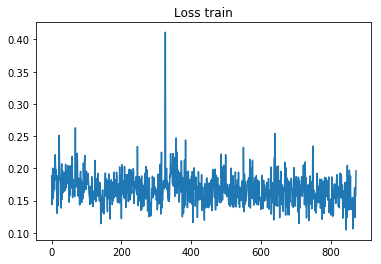


11 epoch: train loss 0.18135625
val loss: 0.061197642 test loss:  0.060941245

12 epoch: train loss 0.17475131
val loss: 0.05768429 test loss:  0.05766825

13 epoch: train loss 0.15702224
val loss: 0.05437109 test loss:  0.054263208

14 epoch: train loss 0.14913175
val loss: 0.051786184 test loss:  0.051528398

15 epoch: train loss 0.13685898
val loss: 0.048950683 test loss:  0.04914416

16 epoch: train loss 0.13632089
val loss: 0.047340315 test loss:  0.047128804

17 epoch: train loss 0.12810285
val loss: 0.045424968 test loss:  0.045555588

18 epoch: train loss 0.11828204
val loss: 0.04388038 test loss:  0.043762386

19 epoch: train loss 0.10983255
val loss: 0.042210203 test loss:  0.042101067

20 epoch: train loss 0.10722449
val loss: 0.041103736 test loss:  0.04088644


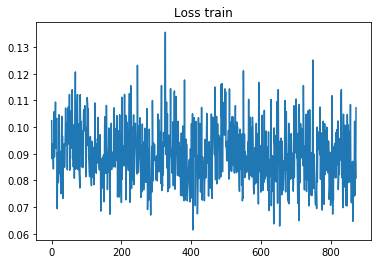


21 epoch: train loss 0.0996004
val loss: 0.03967105 test loss:  0.03961866

22 epoch: train loss 0.09895558
val loss: 0.038628347 test loss:  0.038618106

23 epoch: train loss 0.09269442
val loss: 0.037755463 test loss:  0.037762012

24 epoch: train loss 0.09096105
val loss: 0.036693692 test loss:  0.036590673

25 epoch: train loss 0.08962953
val loss: 0.035949945 test loss:  0.03594622

26 epoch: train loss 0.08280911
val loss: 0.035027564 test loss:  0.034973733

27 epoch: train loss 0.08275183
val loss: 0.03434144 test loss:  0.03432473

28 epoch: train loss 0.078784384
val loss: 0.033911448 test loss:  0.0337954

29 epoch: train loss 0.077495284
val loss: 0.033419397 test loss:  0.03340935

30 epoch: train loss 0.07052142
val loss: 0.032626938 test loss:  0.032599766


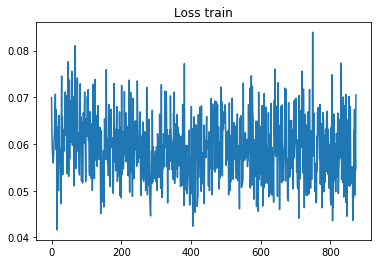


31 epoch: train loss 0.07014868
val loss: 0.032207128 test loss:  0.032294627

32 epoch: train loss 0.067031614
val loss: 0.03149373 test loss:  0.031562593

33 epoch: train loss 0.06672518
val loss: 0.031111524 test loss:  0.031052884

34 epoch: train loss 0.06294909
val loss: 0.030769339 test loss:  0.030774405

35 epoch: train loss 0.06014603
val loss: 0.030358145 test loss:  0.030290995

36 epoch: train loss 0.06025262
val loss: 0.029950734 test loss:  0.029991485

37 epoch: train loss 0.058210723
val loss: 0.029553715 test loss:  0.02956787

38 epoch: train loss 0.053765476
val loss: 0.02927995 test loss:  0.029316707

39 epoch: train loss 0.05105214
val loss: 0.029002741 test loss:  0.029057296

40 epoch: train loss 0.048877906
val loss: 0.028720995 test loss:  0.028783336


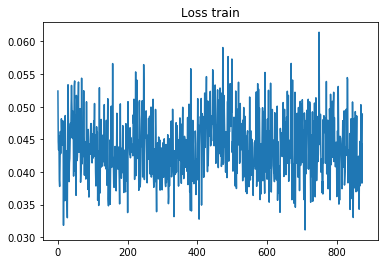


41 epoch: train loss 0.05006803
val loss: 0.028408242 test loss:  0.028523574

42 epoch: train loss 0.046691105
val loss: 0.028148424 test loss:  0.028159432

43 epoch: train loss 0.04579191
val loss: 0.02791022 test loss:  0.028009938

44 epoch: train loss 0.04648702
val loss: 0.027674431 test loss:  0.027770279

45 epoch: train loss 0.045852832
val loss: 0.027492467 test loss:  0.027630365

46 epoch: train loss 0.042738523
val loss: 0.027340697 test loss:  0.02739976

47 epoch: train loss 0.04462011
val loss: 0.027191516 test loss:  0.027270231

48 epoch: train loss 0.0449903
val loss: 0.026903283 test loss:  0.027019832

49 epoch: train loss 0.043505754
val loss: 0.026511883 test loss:  0.02669774

50 epoch: train loss 0.044487704
val loss: 0.026345141 test loss:  0.026488751


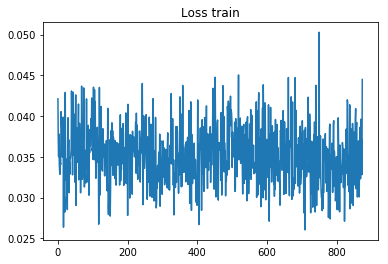


51 epoch: train loss 0.043083906
val loss: 0.026049895 test loss:  0.026222583

52 epoch: train loss 0.044191223
val loss: 0.0258279 test loss:  0.02593459

53 epoch: train loss 0.04237736
val loss: 0.025695732 test loss:  0.025839886

54 epoch: train loss 0.038901795
val loss: 0.025485586 test loss:  0.025616312

55 epoch: train loss 0.038449053
val loss: 0.025469178 test loss:  0.025596973

56 epoch: train loss 0.03954798
val loss: 0.025689451 test loss:  0.02578103

57 epoch: train loss 0.043884404
val loss: 0.026082424 test loss:  0.02604667

58 epoch: train loss 0.04108856
val loss: 0.025933167 test loss:  0.025715444

59 epoch: train loss 0.03564564
val loss: 0.025052648 test loss:  0.02494441

60 epoch: train loss 0.034246594
val loss: 0.02437429 test loss:  0.024313206


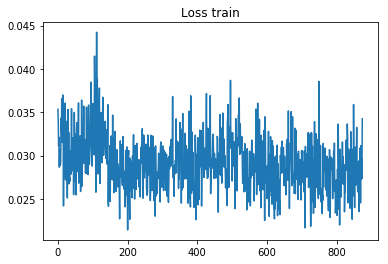


61 epoch: train loss 0.033096578
val loss: 0.023790296 test loss:  0.023766758

62 epoch: train loss 0.031268574
val loss: 0.023370462 test loss:  0.02347285

63 epoch: train loss 0.031746518
val loss: 0.023216894 test loss:  0.023280626

64 epoch: train loss 0.028998587
val loss: 0.023006309 test loss:  0.023121709

65 epoch: train loss 0.03066576
val loss: 0.022885859 test loss:  0.022954954

66 epoch: train loss 0.02936187
val loss: 0.022778602 test loss:  0.022867639

67 epoch: train loss 0.030044153
val loss: 0.02268388 test loss:  0.022792296

68 epoch: train loss 0.02831407
val loss: 0.022597022 test loss:  0.022759166

69 epoch: train loss 0.02713006
val loss: 0.022505356 test loss:  0.022671849

70 epoch: train loss 0.028525656
val loss: 0.02244308 test loss:  0.022622159


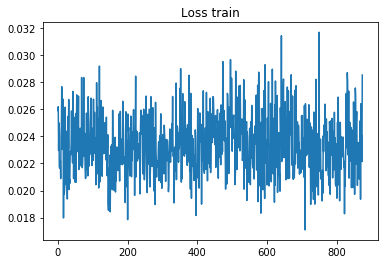


71 epoch: train loss 0.025864167
val loss: 0.022247786 test loss:  0.022503741

72 epoch: train loss 0.027017538
val loss: 0.022227403 test loss:  0.022386976

73 epoch: train loss 0.024941685
val loss: 0.02211243 test loss:  0.022326542

74 epoch: train loss 0.025511941
val loss: 0.022151183 test loss:  0.022326052

75 epoch: train loss 0.024291258
val loss: 0.022184331 test loss:  0.022397436

76 epoch: train loss 0.024417415
val loss: 0.022232804 test loss:  0.022416767

77 epoch: train loss 0.027608752
val loss: 0.022330992 test loss:  0.02256117

78 epoch: train loss 0.025295254
val loss: 0.022359556 test loss:  0.022622682

79 epoch: train loss 0.025767714
val loss: 0.022382235 test loss:  0.022573486

80 epoch: train loss 0.024370192
val loss: 0.02255864 test loss:  0.02267759


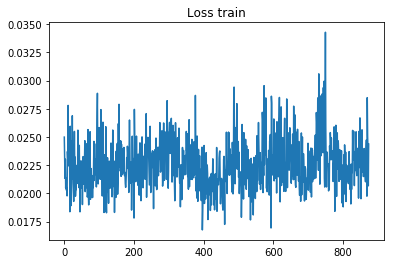


81 epoch: train loss 0.026120365
val loss: 0.022806177 test loss:  0.02288711

82 epoch: train loss 0.026075587
val loss: 0.022760514 test loss:  0.0228427

83 epoch: train loss 0.024628814
val loss: 0.022527026 test loss:  0.022548497

84 epoch: train loss 0.021858305
val loss: 0.022176549 test loss:  0.022204462

85 epoch: train loss 0.021814954
val loss: 0.021795735 test loss:  0.021851538

86 epoch: train loss 0.020680655
val loss: 0.021400625 test loss:  0.021518614

87 epoch: train loss 0.021404276
val loss: 0.021164233 test loss:  0.021248642

88 epoch: train loss 0.02023666
val loss: 0.02097257 test loss:  0.021183737

89 epoch: train loss 0.021422783
val loss: 0.020970086 test loss:  0.021087682

90 epoch: train loss 0.019911427
val loss: 0.020857101 test loss:  0.021023547


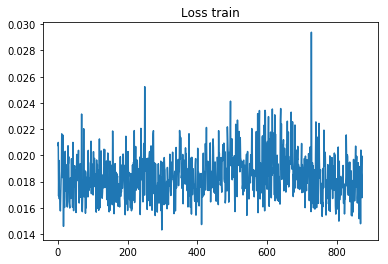


91 epoch: train loss 0.019730894
val loss: 0.020824147 test loss:  0.020948445

92 epoch: train loss 0.020094758
val loss: 0.020662814 test loss:  0.02092402

93 epoch: train loss 0.018677702
val loss: 0.020732054 test loss:  0.020797193

94 epoch: train loss 0.01883406
val loss: 0.020676037 test loss:  0.020833675

95 epoch: train loss 0.019102553
val loss: 0.020685302 test loss:  0.020740245

96 epoch: train loss 0.01839112
val loss: 0.020619517 test loss:  0.020728031

97 epoch: train loss 0.018427365
val loss: 0.020527331 test loss:  0.02069146

98 epoch: train loss 0.017485656
val loss: 0.020481354 test loss:  0.020606272

99 epoch: train loss 0.018085934
val loss: 0.020425582 test loss:  0.02062289


'\n# 5-2. run trained policy to get dataset D_pi\n#returns2 = eval_policy(game, 25, sess, state, out, env, data_gen = False, verbose = True)\n'

In [36]:
# 5. train nn with new dataset and check the performance
seed, it_num, batch_size, epoch, num_rollouts = 1, 1e+5, 100, 100, 25
batch_size2  =  int(batch_size/3)
set_seed(seed)
sess = get_session()
env = gym.make(game)

# 5-1. train from human(expert) Data including evaluation during training
sess, state, action, out, eval_list = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, new_xt, new_yt, x_val, y_val, x_test, y_test, evaluate = True, env = env)
'''
# 5-2. run trained policy to get dataset D_pi
#returns2 = eval_policy(game, 25, sess, state, out, env, data_gen = False, verbose = True)
'''
# run expert to compare performance 
#exp_returns = run_expert(game, num_rollouts = 20)

obs (1, 376) (1, 376)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 1.2789474
val loss: 1.4156644 test loss:  1.3473761


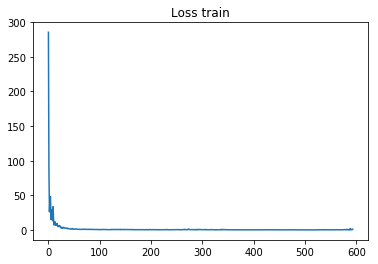


1 epoch: train loss 1.3213406
val loss: 0.38435426 test loss:  0.3807884

2 epoch: train loss 0.39062393
val loss: 0.3004025 test loss:  0.29427674

3 epoch: train loss 0.30691
val loss: 0.24066967 test loss:  0.24160632

4 epoch: train loss 0.18754768
val loss: 0.23058954 test loss:  0.23678745

5 epoch: train loss 0.1752677
val loss: 0.15400565 test loss:  0.15356486

6 epoch: train loss 0.4541666
val loss: 0.15138842 test loss:  0.152456

7 epoch: train loss 0.16398859
val loss: 0.15943159 test loss:  0.15523721

8 epoch: train loss 0.13605832
val loss: 0.13505028 test loss:  0.13275659

9 epoch: train loss 0.11856224
val loss: 0.11317857 test loss:  0.11356295

10 epoch: train loss 0.18497662
val loss: 0.10809077 test loss:  0.10896941


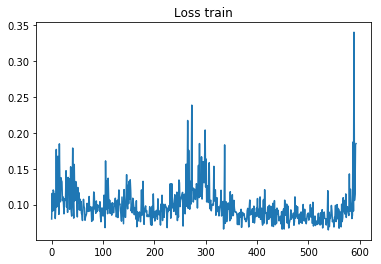


11 epoch: train loss 0.12818052
val loss: 0.10515234 test loss:  0.10535177

12 epoch: train loss 0.09278748
val loss: 0.094292454 test loss:  0.09410046

13 epoch: train loss 0.08924117
val loss: 0.08817425 test loss:  0.08858269

14 epoch: train loss 0.08164398
val loss: 0.08384852 test loss:  0.084185876

15 epoch: train loss 0.07009511
val loss: 0.08169859 test loss:  0.08147885

16 epoch: train loss 0.07846929
val loss: 0.0771317 test loss:  0.0776781

17 epoch: train loss 0.06932509
val loss: 0.07388546 test loss:  0.0743339

18 epoch: train loss 0.06852022
val loss: 0.071695566 test loss:  0.07213976

19 epoch: train loss 0.06835501
val loss: 0.06894126 test loss:  0.0694711

20 epoch: train loss 0.0602795
val loss: 0.066554636 test loss:  0.06715589


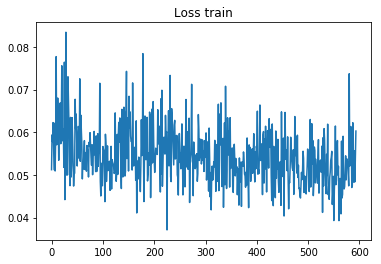


21 epoch: train loss 0.053675596
val loss: 0.06401722 test loss:  0.06443707

22 epoch: train loss 0.05032848
val loss: 0.062322732 test loss:  0.06285906

23 epoch: train loss 0.052299812
val loss: 0.060664065 test loss:  0.061257474

24 epoch: train loss 0.049130306
val loss: 0.05934899 test loss:  0.059957936

25 epoch: train loss 0.04624334
val loss: 0.057741288 test loss:  0.058112778

26 epoch: train loss 0.046000116
val loss: 0.05622169 test loss:  0.056838207

27 epoch: train loss 0.04367427
val loss: 0.054991752 test loss:  0.055196214

28 epoch: train loss 0.04411549
val loss: 0.054052122 test loss:  0.054658227

29 epoch: train loss 0.044287656
val loss: 0.05270222 test loss:  0.05316515

30 epoch: train loss 0.043217827
val loss: 0.05171841 test loss:  0.052233763


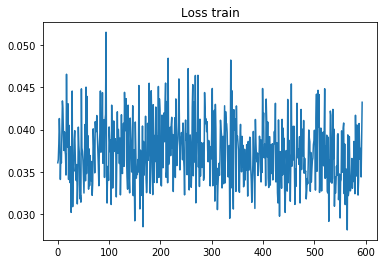


31 epoch: train loss 0.04171516
val loss: 0.05120295 test loss:  0.05170501

32 epoch: train loss 0.041829024
val loss: 0.05028456 test loss:  0.050735384

33 epoch: train loss 0.039262097
val loss: 0.049546313 test loss:  0.04996405

34 epoch: train loss 0.038588867
val loss: 0.048890427 test loss:  0.04932991

35 epoch: train loss 0.03791858
val loss: 0.048037276 test loss:  0.048413526

36 epoch: train loss 0.034878373
val loss: 0.047471292 test loss:  0.047789346

37 epoch: train loss 0.035092145
val loss: 0.047013387 test loss:  0.047306426

38 epoch: train loss 0.035165966
val loss: 0.046698727 test loss:  0.046815038

39 epoch: train loss 0.034295328
val loss: 0.04597602 test loss:  0.04611881

40 epoch: train loss 0.03166063
val loss: 0.0454024 test loss:  0.045780767


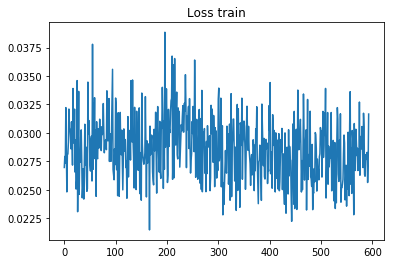


41 epoch: train loss 0.032307163
val loss: 0.04515068 test loss:  0.045167945

42 epoch: train loss 0.031430952
val loss: 0.04453693 test loss:  0.044790894

43 epoch: train loss 0.03002945
val loss: 0.044115875 test loss:  0.044376675

44 epoch: train loss 0.029669283
val loss: 0.04414265 test loss:  0.044131186

45 epoch: train loss 0.029493827
val loss: 0.043586846 test loss:  0.04384828

46 epoch: train loss 0.028942287
val loss: 0.04335359 test loss:  0.043550286

47 epoch: train loss 0.029060682
val loss: 0.04286798 test loss:  0.043043554

48 epoch: train loss 0.029122602
val loss: 0.042460103 test loss:  0.042719953

49 epoch: train loss 0.027361436
val loss: 0.04211603 test loss:  0.04230603

50 epoch: train loss 0.027855454
val loss: 0.04182294 test loss:  0.042060934


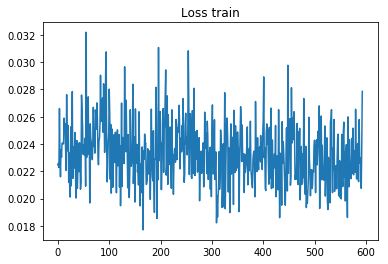


51 epoch: train loss 0.026637934
val loss: 0.041535195 test loss:  0.04184885

52 epoch: train loss 0.025539484
val loss: 0.041230634 test loss:  0.04164472

53 epoch: train loss 0.026383255
val loss: 0.04096725 test loss:  0.041319586

54 epoch: train loss 0.024928551
val loss: 0.040754694 test loss:  0.0413161

55 epoch: train loss 0.02407985
val loss: 0.04051889 test loss:  0.04095006

56 epoch: train loss 0.02475699
val loss: 0.040280905 test loss:  0.040726807

57 epoch: train loss 0.02377741
val loss: 0.03989384 test loss:  0.040398523

58 epoch: train loss 0.023556976
val loss: 0.03974669 test loss:  0.040339094

59 epoch: train loss 0.023375655
val loss: 0.03955235 test loss:  0.040040113

60 epoch: train loss 0.02318858
val loss: 0.039341114 test loss:  0.03990036


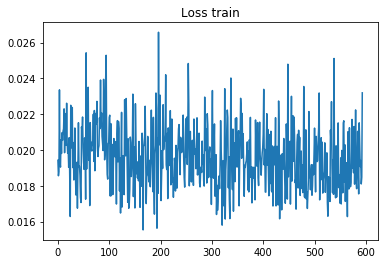


61 epoch: train loss 0.023092113
val loss: 0.03918943 test loss:  0.03966018

62 epoch: train loss 0.022586627
val loss: 0.03894163 test loss:  0.039530188

63 epoch: train loss 0.021463457
val loss: 0.03880084 test loss:  0.039293632

64 epoch: train loss 0.021448694
val loss: 0.03866039 test loss:  0.03923868

65 epoch: train loss 0.021499759
val loss: 0.038508337 test loss:  0.039028026

66 epoch: train loss 0.020978598
val loss: 0.03838458 test loss:  0.038956426

67 epoch: train loss 0.020798808
val loss: 0.0381785 test loss:  0.038848657

68 epoch: train loss 0.020620408
val loss: 0.038121644 test loss:  0.03878252

69 epoch: train loss 0.020458607
val loss: 0.03797368 test loss:  0.038732402

70 epoch: train loss 0.019948652
val loss: 0.03789317 test loss:  0.038586337


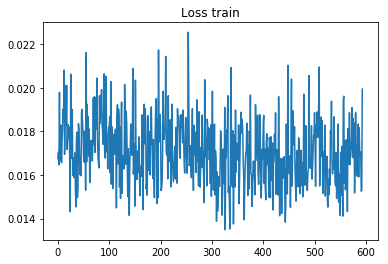


71 epoch: train loss 0.019366262
val loss: 0.03779802 test loss:  0.038434457

72 epoch: train loss 0.018879125
val loss: 0.037676882 test loss:  0.038387425

73 epoch: train loss 0.019202624
val loss: 0.03753392 test loss:  0.038265895

74 epoch: train loss 0.018288406
val loss: 0.037414927 test loss:  0.038095772

75 epoch: train loss 0.018126493
val loss: 0.037242413 test loss:  0.03808743

76 epoch: train loss 0.018048497
val loss: 0.037205897 test loss:  0.037996706

77 epoch: train loss 0.01821428
val loss: 0.03702328 test loss:  0.03787746

78 epoch: train loss 0.018009864
val loss: 0.03693887 test loss:  0.03776991

79 epoch: train loss 0.018251127
val loss: 0.036936056 test loss:  0.037757892

80 epoch: train loss 0.018163987
val loss: 0.036868464 test loss:  0.037692428


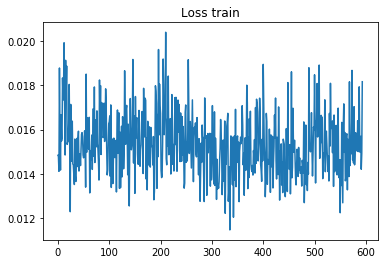


81 epoch: train loss 0.01819745
val loss: 0.036739502 test loss:  0.037509184

82 epoch: train loss 0.018234959
val loss: 0.03653883 test loss:  0.037377127

83 epoch: train loss 0.0183381
val loss: 0.036447417 test loss:  0.037383694

84 epoch: train loss 0.017987935
val loss: 0.03636616 test loss:  0.037234664

85 epoch: train loss 0.017590487
val loss: 0.03634484 test loss:  0.037236065

86 epoch: train loss 0.017687475
val loss: 0.0362212 test loss:  0.037003927

87 epoch: train loss 0.017202456
val loss: 0.036148097 test loss:  0.03704037

88 epoch: train loss 0.01743699
val loss: 0.036112588 test loss:  0.03689831

89 epoch: train loss 0.01694264
val loss: 0.036043264 test loss:  0.03692233

90 epoch: train loss 0.01680447
val loss: 0.035973143 test loss:  0.036807287


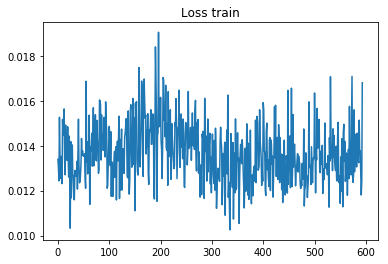


91 epoch: train loss 0.01686961
val loss: 0.036020253 test loss:  0.036799435

92 epoch: train loss 0.016731795
val loss: 0.035871774 test loss:  0.036718015

93 epoch: train loss 0.01668828
val loss: 0.035750926 test loss:  0.03672887

94 epoch: train loss 0.016919037
val loss: 0.03570964 test loss:  0.0366738

95 epoch: train loss 0.01673379
val loss: 0.035732068 test loss:  0.036597293

96 epoch: train loss 0.016775122
val loss: 0.035652418 test loss:  0.03651972

97 epoch: train loss 0.01588586
val loss: 0.035501976 test loss:  0.036478803

98 epoch: train loss 0.0157916
val loss: 0.035472497 test loss:  0.036366206

99 epoch: train loss 0.015249283
val loss: 0.03528577 test loss:  0.036244992


In [74]:
# setup for DAgger
game = 'Humanoid-v2'
data = 'Humanoid-v2'
policy_fn = load_policy.load_policy('./experts/'+ str(game)+'.pkl')
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

seed, it_num, batch_size, epoch, num_rollouts = 1, 1e+5, 100, 100, _
batch_size2  =  int(batch_size/3)
set_seed(seed)
sess = get_session()
env = gym.make(game)
# 1. train from human(expert) Data
sess, state, action, out, returns = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test, evaluate= True, env = env)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
obs (1, 376) (1, 376)


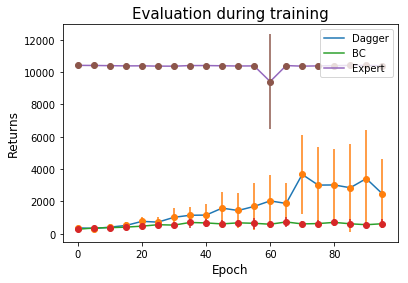

In [ ]:
#plot mean and std w.r.t epoch

mean = []
std = []
mean_bc, std_bc = [], []
for idx in range(len(eval_list)):
    mean.append(eval_list[idx][0])
    std.append(eval_list[idx][1])
    mean_bc.append(returns[idx][0])
    std_bc.append(returns[idx][1])

exp_returns, exp_mean, exp_std = run_expert(game, num_rollouts = 10, it = 20)
xrange = np.arange(20)*5

plt.plot(xrange, mean, label='Dagger')
plt.errorbar(xrange, mean, std, linestyle='None', marker='o')
plt.plot(xrange, mean_bc, label='BC')
plt.errorbar(xrange, mean_bc, std_bc, linestyle='None', marker='o')
plt.plot(xrange, exp_mean, label='Expert')
plt.errorbar(xrange, exp_mean, exp_std, linestyle='None', marker='o')


plt.xlabel('Epoch', size=12)
plt.ylabel('Returns',size =12)
plt.title('Evaluation during training', size = 15)
plt.legend(loc='upper right')
plt.show()  

# Bonus: BC with different network architecture 

In [68]:
# increase layer depth
def model(state_dim, action_dim):
    state = tf.placeholder(tf.float32, [None, state_dim])
    action = tf.placeholder(tf.float32, [None, 1, action_dim])
    if state_dim > 100:
        with tf.variable_scope('fc'):
            fc1 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(state, 1024))
            fc2 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc1, 1024))
            fc3 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc2, 1024))
            fc4 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc3, 1024))
            fc5 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc4, 512))
            fc6 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc5, 256))
            out = tf.contrib.layers.fully_connected(fc6, action_dim, activation_fn=None)   
    else:
        with tf.variable_scope('fc'):
            fc1 = tf.contrib.layers.fully_connected(state, 1024)
            out = tf.contrib.layers.fully_connected(fc1, action_dim, activation_fn=None)           
    
    out = tf.reshape(out, [tf.shape(state)[0], 1, action_dim])
    return state, action, out

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 0.16652042
val loss: 0.41565338 test loss:  0.39750162


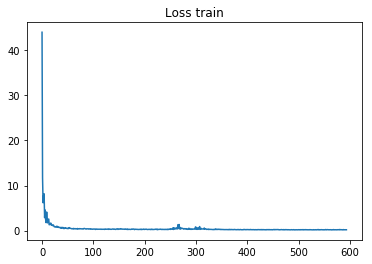


1 epoch: train loss 0.1262889
val loss: 0.15073112 test loss:  0.15026477

2 epoch: train loss 0.127388
val loss: 0.12030739 test loss:  0.12067899

3 epoch: train loss 0.10679226
val loss: 0.10602019 test loss:  0.106107086

4 epoch: train loss 0.09201822
val loss: 0.0950583 test loss:  0.0952561

5 epoch: train loss 0.08206045
val loss: 0.08918494 test loss:  0.08960585

6 epoch: train loss 0.07257975
val loss: 0.08241985 test loss:  0.08320927

7 epoch: train loss 0.06878947
val loss: 0.077712975 test loss:  0.07831547

8 epoch: train loss 0.06639698
val loss: 0.07439398 test loss:  0.075387485

9 epoch: train loss 0.06533434
val loss: 0.07178078 test loss:  0.07258503

10 epoch: train loss 0.059137307
val loss: 0.0687118 test loss:  0.06964379


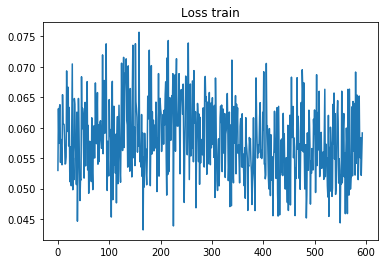


11 epoch: train loss 0.05566659
val loss: 0.06636559 test loss:  0.06710067

12 epoch: train loss 0.055991516
val loss: 0.064673506 test loss:  0.065236494

13 epoch: train loss 0.051454224
val loss: 0.0622802 test loss:  0.06292614

14 epoch: train loss 0.051241837
val loss: 0.060477775 test loss:  0.0612094

15 epoch: train loss 0.048392124
val loss: 0.059159476 test loss:  0.05968794

16 epoch: train loss 0.046950594
val loss: 0.057835184 test loss:  0.058231585

17 epoch: train loss 0.0447082
val loss: 0.056319136 test loss:  0.056990262

18 epoch: train loss 0.04322574
val loss: 0.05494207 test loss:  0.0555157

19 epoch: train loss 0.042251244
val loss: 0.05378648 test loss:  0.0542437

20 epoch: train loss 0.041778054
val loss: 0.052994724 test loss:  0.053517256


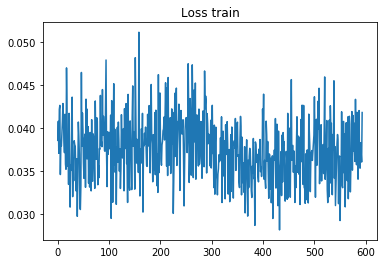


21 epoch: train loss 0.040037017
val loss: 0.052119516 test loss:  0.052615546

22 epoch: train loss 0.038660415
val loss: 0.051334422 test loss:  0.051906433

23 epoch: train loss 0.03903462
val loss: 0.050354153 test loss:  0.050685596

24 epoch: train loss 0.037255142
val loss: 0.049549058 test loss:  0.049926057
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

iter 0
mean return 393.0825580817108
std of return 0.0

iter 1
mean return 617.646057499677
std of return 224.56349941796628

iter 2
mean return 537.7159274433255
std of return 215.3992298706733

iter 3
mean return 477.0707438411524
std of return 214.0820778441839

iter 4
mean return 461.4311664541031
std of return 194.01879900321157

iter 5
mean return 449.0899914491387
std of return 179.251038978085

iter 6
mean return 460.5419368816254
std of return 168.30829965286117

iter 

In [69]:
# split data, create env
data = 'Humanoid-v2'
game = 'Humanoid-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)
env = gym.make(game)

# training deep neural nets
seed = 1
set_seed(seed)
sess = get_session()
it_num = int(1e+5)
batch_size = 100
batch_size2 = int(batch_size/3)
epoch = 25
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test, True, env)


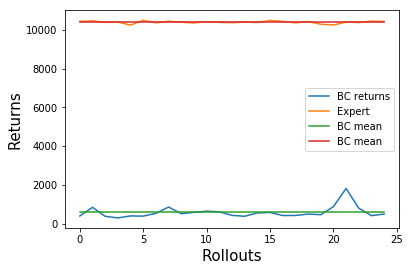

<Figure size 432x288 with 0 Axes>

In [71]:
# plot returns of BC and experts
plt.plot(returns, label = 'BC returns')
plt.xlabel('Rollouts', size=15)
plt.ylabel('Returns',size =15)
expert = [10438.186857983954, 10471.131848812303, 10389.244896091363, 10408.525369725054, 10249.73483750236, 10500.494293676069, 10365.63592228353, 10449.819812393624, 10399.94066843901, 10362.921788183248, 10427.754227585881, 10389.807021159531, 10375.111270627773, 10405.069458543141, 10381.935291587313, 10489.363191346045, 10440.62519389299, 10365.833474975829, 10430.640306509, 10295.54458154796, 10255.717391407743, 10405.162307972787, 10382.36730720193, 10454.536386206888, 10436.20845939734]
plt.plot(expert,label = 'Expert')
plt.plot(np.mean(returns)*np.ones((25,)), label = 'BC mean')
plt.plot(np.mean(expert)*np.ones((25,)), label = 'BC mean')
plt.legend()
plt.figure()
plt.show()